# Predicting diabetes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

df = pd.read_csv('diabetes.csv')
#df.head()
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## Plotting data

C:\Users\preve\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


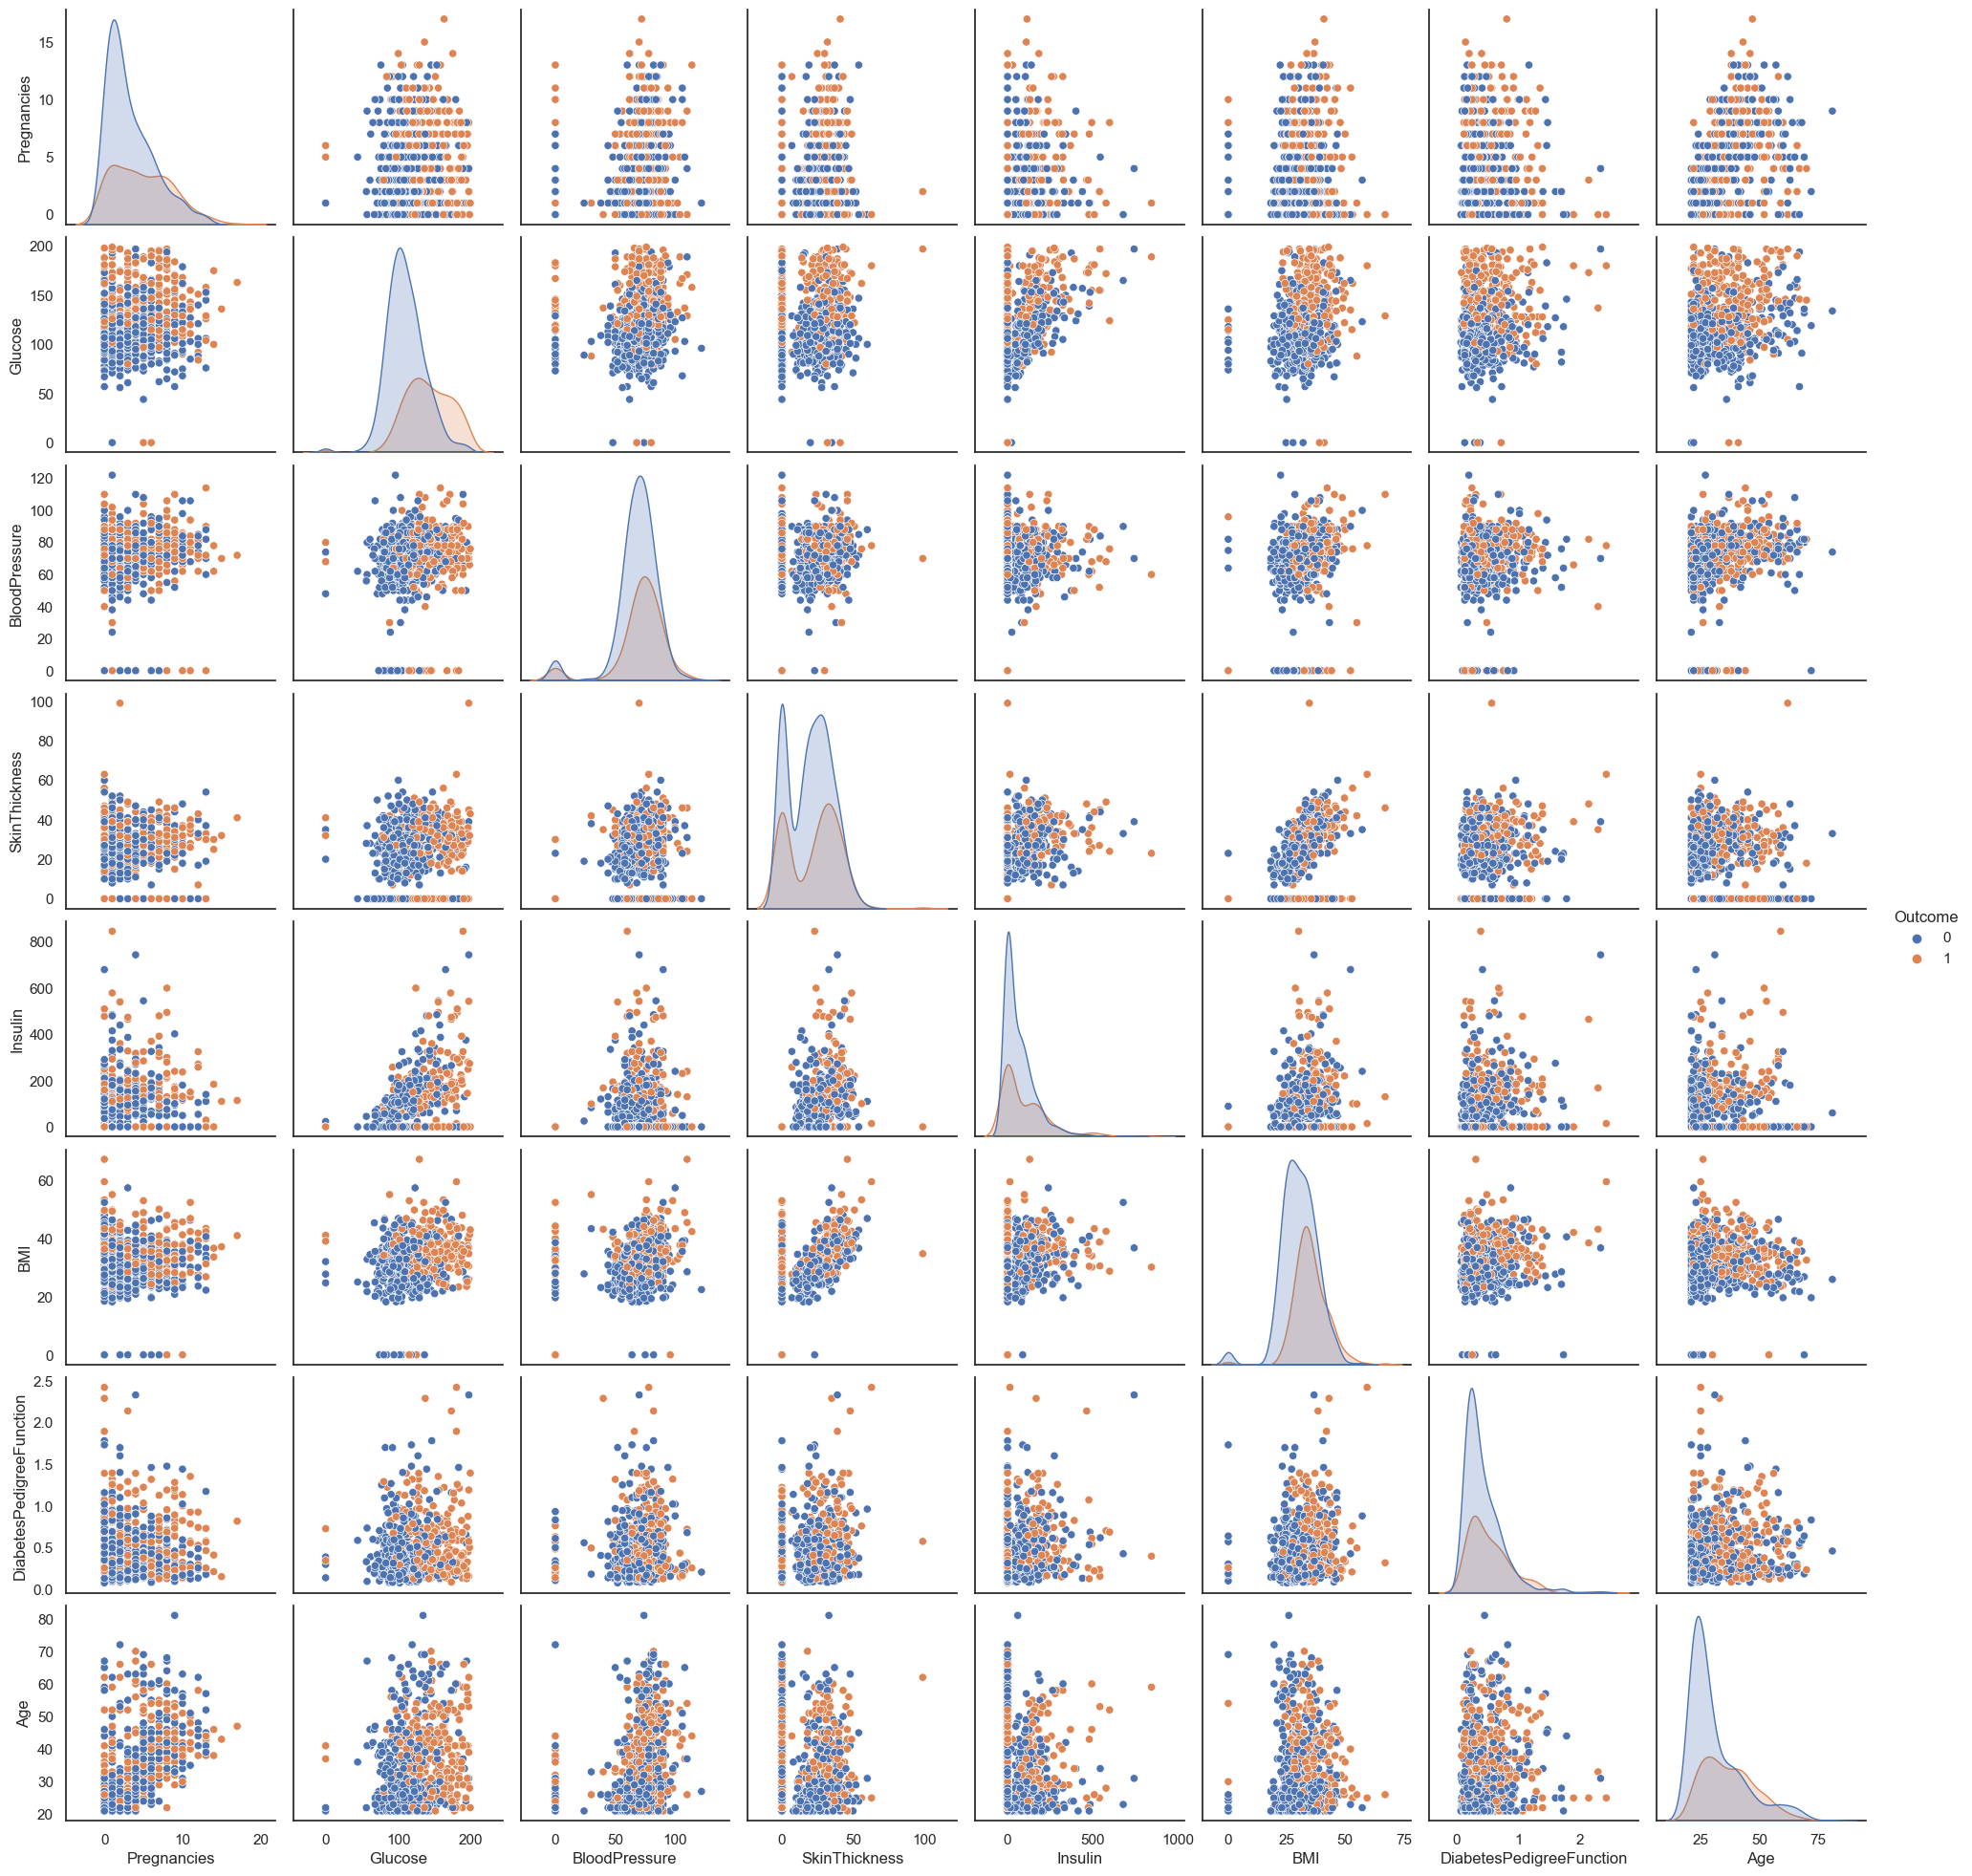

In [2]:
import seaborn as sns

# Create a matrix plot
sns.set(style="white")  # Set the style to "white" for a clean background
sns.pairplot(df, hue='Outcome')

# Show the plot
plt.show()

## Principal Component Analysis (PCA)

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sample data (replace this with your dataset)
data = X

### Standardize data

In [4]:
# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)

### Create Scree Plot

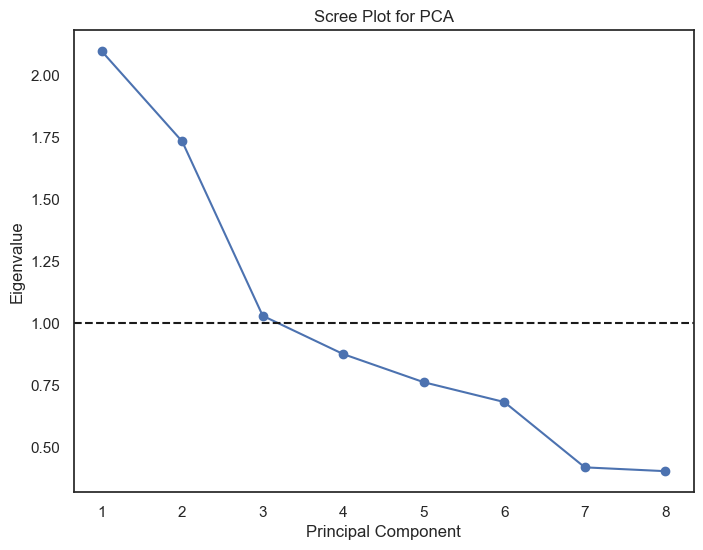

In [5]:
# Fit PCA and obtain the eigenvalues
pca = PCA()
pca.fit(data_standardized)
eigenvalues = pca.explained_variance_

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.axhline(y=1, color='k', linestyle='--')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

### Apply PCA

In [6]:
# Create PCA object
pca = PCA(n_components=3)

# Apply PCA to data
transformed_data = pca.fit_transform(data_standardized)

# Get the principal components and explained variance
components = pca.components_

### Normalize transformed data

In [7]:
# Normalize the principal components to the range [-1, 1]
normalized_transformed_data = 2* (transformed_data - transformed_data.min(axis=0)) / (transformed_data.max(axis=0) - transformed_data.min(axis=0)) - 1
normalized_transformed_data = normalized_transformed_data/2

# Scatter plot of the normalized transformed data
normalized_transformed_data = pd.DataFrame(normalized_transformed_data)

### Create biplot

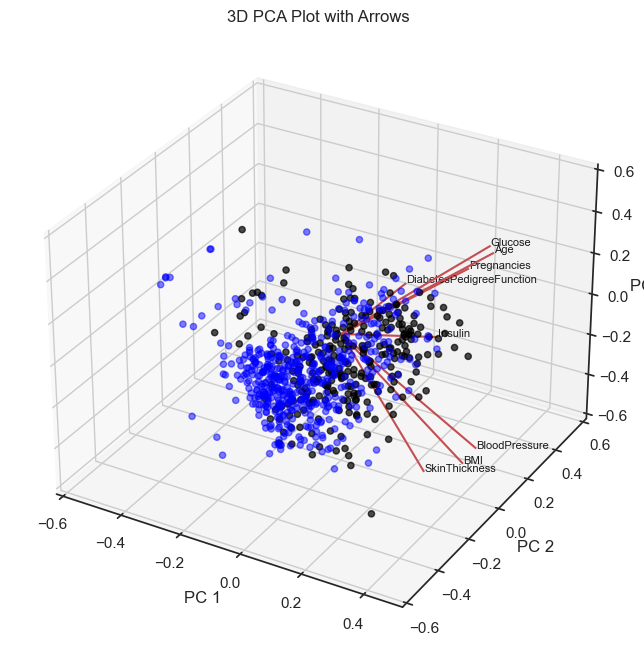

In [8]:
# Plot the 3D scatter plot with arrows
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(normalized_transformed_data.loc[df['Outcome'] == 0, 0], normalized_transformed_data.loc[df['Outcome'] == 0, 1], normalized_transformed_data.loc[df['Outcome'] == 0, 2], c='blue', marker='o', alpha=.5)
scatter = ax.scatter(normalized_transformed_data.loc[df['Outcome'] == 1, 0], normalized_transformed_data.loc[df['Outcome'] == 1, 1], normalized_transformed_data.loc[df['Outcome'] == 1, 2], c='black', marker='o', alpha=.7)

# Add loading of variables
for i in range(components.shape[1]):
    ax.quiver(0, 0, 0, components[0, i], components[1, i], components[2, i], 
              color='r', arrow_length_ratio=0)
    ax.text(components[0, i], components[1, i], components[2, i], f'{X.columns[i]}', 
            color='k', fontsize=8)

# Add labels
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('3D PCA Plot with Arrows')

# Set limits
ax.set_xlim([-.6, .5])
ax.set_ylim([-.6, .6])
ax.set_zlim([-.6, .6])

# Show the plot
plt.show()

#### Create animated graph

In [9]:
from matplotlib.animation import FuncAnimation

# Animation function to rotate the plot around z-axis
def update(num, scatter, ax):
    ax.view_init(elev=10, azim=num)
    return scatter,

# Create the animation
animation = FuncAnimation(fig, update, frames=range(-90, 90, 1), fargs=(scatter, ax), interval=100)

# Save the animation as a GIF
animation.save('pca_rotation.gif', writer='pillow')

## Apply Machine Learning Models

In [10]:
class Models:

    ## Split dataset to train and test sets (class variables)
    X_train, X_test, y_train, y_test = [], [], [], []

    @classmethod
    def split_data(cls, X, y):
        cls.X_train, cls.X_test, cls.y_train, cls.y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    ## All models (instances of class Models) are stored in a list
    all_instances = []

    # Class method for objects creation (it creates and instance and stores it in the list of objects)
    @classmethod
    def create_model(cls, name, mdl):
        new_instance = cls(name, mdl)
        cls.all_instances.append(new_instance)
        return new_instance

    # Instance method to get all variables
    def get(self):
        return {
            "name": self.name,
            "mdl_fitted": self.mdl_fitted,
            "y_prob": self.y_prob,
            "conf_matrix": self.conf_matrix,
            "report": self.report,
            "fpr": self.fpr,
            "tpr": self.tpr,
            "thresholds": self.thresholds,
            "roc_auc": self.roc_auc,
            "y_pred": self.y_pred
        }
    

    ## Class method to print metrics from all fitted models
    @classmethod
    def metrics(cls):
        # confusion matrix
        print('Confusion Matrix')
        for instance in cls.all_instances:
            print(f" {instance.get()['name']}:\n {instance.get()['conf_matrix']}")
        print("\n")
        
        # report
        print('Classification Report')
        for instance in cls.all_instances:
            print(f" {instance.get()['name']}:\n {instance.get()['report']}")
        print("\n")

        # plot the ROC curve
        plt.figure(figsize=(8, 6))
        for instance in cls.all_instances:
            plt.plot(instance.get()['fpr'], instance.get()['tpr'], lw=2, label=f"{instance.get()['name']} (AUC = {instance.get()['roc_auc']:.2f})")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()


    ## Instance method to make predictions for new data
    def make_predictions(self, new_data):
        return self.mdl.predict(new_data)

    ## Create instance
    def __init__(self, name, mdl):
        self.name = name
        self.mdl = mdl
        self.mdl_fitted = []
        self.y_prob = []
        self.conf_matrix = []
        self.report = []
        self.fpr = [] 
        self.tpr = []
        self.thresholds = [] 
        self.roc_auc = []     
        self.y_pred = []

        ## 
        # Train the classifier on the training data
        self.mdl_fitted = self.mdl.fit(Models.X_train, Models.y_train)
    
        # Make predictions on the testing data
        self.y_pred = self.mdl.predict(Models.X_test)

        # Evaluate the classifier
        self.conf_matrix = confusion_matrix(Models.y_test, self.y_pred)
        self.report = classification_report(Models.y_test, self.y_pred)

        # Predict the probability of the positive class (class 1) for the test set
        self.y_prob = self.mdl.predict_proba(Models.X_test)[:, 1]

        # Compute ROC curve and ROC area for each class
        self.fpr, self.tpr, self.thresholds = roc_curve(Models.y_test, self.y_prob)
        self.roc_auc = auc(self.fpr, self.tpr)  

### Apply Models

Confusion Matrix
 randomforest:
 [[77 22]
 [21 34]]
 boostedtrees:
 [[77 22]
 [18 37]]


Classification Report
 randomforest:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154

 boostedtrees:
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        99
           1       0.63      0.67      0.65        55

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154





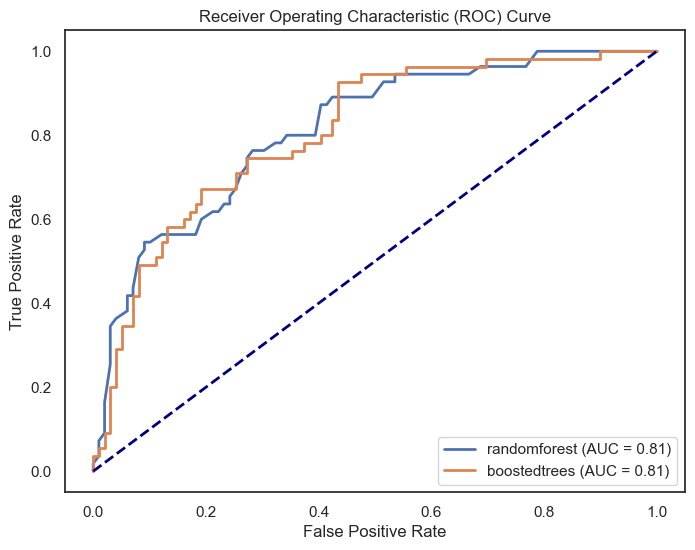

In [11]:
# Split dataset to trean and test set (using the class method 'split_data')
Models.split_data(X, y)

# Create models (instances)
random_forest = Models.create_model('randomforest', RandomForestClassifier(n_estimators=100, random_state=42))
boosted_trees = Models.create_model('boostedtrees', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42))

# Rpint metrics from all models (using the class method 'metrics')
Models.metrics()

### Make predictions for new data

In [12]:
new_observation = Models.X_test.iloc[0].to_frame().transpose()
new_observation

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
668,6.0,98.0,58.0,33.0,190.0,34.0,0.43,43.0


In [13]:
print(f'The model predicted that the person {"has" if random_forest.make_predictions(new_observation)[0]==1 else "does not have"} diabetes.')
print(f'The actual data shows that the person {"has" if Models.y_test.iloc[0]==1 else "does not have"} diabetes.')

The model predicted that the person does not have diabetes.
The actual data shows that the person does not have diabetes.


## Appendix (PCA with only two principal components)

[[-0.1284321  -0.39308257 -0.36000261 -0.43982428 -0.43502617 -0.45194134
  -0.27061144 -0.19802707]
 [-0.59378583 -0.17402908 -0.18389207  0.33196534  0.25078106  0.1009598
   0.122069   -0.62058853]
 [ 0.01308692 -0.46792282  0.53549442  0.2376738  -0.33670893  0.36186463
  -0.43318905 -0.07524755]]


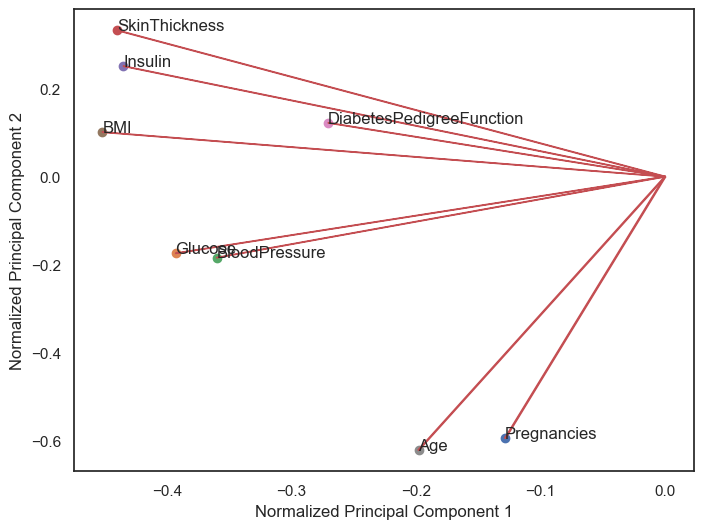

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)

# Perform PCA with 2 components
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(data_standardized)


# Get the principal components and explained variance
components = pca.components_*-1
print(components)

# Plot the loading plot
fig, ax = plt.subplots(figsize=(8, 6))

# Loading plot
for i in range(components.shape[1]):
    ax.scatter(components[0, i], components[1, i])
    ax.arrow(0, 0, components[0, i], components[1, i],
             head_width=0, head_length=0, fc='r', ec='r')

# Add labels and legend
ax.set_xlabel('Normalized Principal Component 1')
ax.set_ylabel('Normalized Principal Component 2')

# Annotate each point with the variable index
for i, txt in enumerate(range(components.shape[1])):
    ax.annotate(f'{X.columns[i]}', (components[0, i], components[1, i]))


# Show the plot
plt.show()
